In [1]:
import torch
# from encoder.encoders import DistributionEncoderTx
from encoder.wormhole_encoder import WormholeEncoder
from generator.wormhole import WormholeGenerator
from datasets.mnist import MNISTDataset
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from mixer.mixer import SetMixer

In [2]:
dataset = MNISTDataset(set_size=10, n_sets=10**4, n_classes=3)
mixer = SetMixer(k=3)

In [3]:
dataloader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=mixer.collate_fn
)

In [4]:
in_dim = 28*28
latent_dim = 64
hidden_dim = 128
set_size = dataset.set_size
device = 'cuda'

enc = WormholeEncoder(dataset.data[0][0].shape, latent_dim, hidden_dim, set_size)
gen = WormholeGenerator(latent_dim, in_dim, hidden_dim, set_size)
optimizer = torch.optim.Adam(list(enc.parameters()) + list(gen.parameters()), lr=1e-4)
enc.to(device)
gen.to(device)

WormholeGenerator(
  (model): DistributionDecoderTx(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): SELU()
      (2): SelfAttention(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (3): Linear(in_features=128, out_features=784, bias=True)
    )
    (multiplier): Linear(in_features=64, out_features=640, bias=True)
  )
)

In [5]:
for epoch in range(10):
    for idx,batch in enumerate(dataloader):
        
        samples = batch['samples'].to(device)
        latent = enc(samples)
        loss = gen.loss(samples.view(-1, *samples.shape[2:]), latent)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx % 100 == 0:
            print(f"epoch {epoch} batch {idx}: loss {loss.item()}")

epoch 0 batch 0: loss 31.068130493164062
epoch 0 batch 100: loss 10.65255069732666
epoch 0 batch 200: loss 8.343475341796875
epoch 0 batch 300: loss 8.727774620056152
epoch 0 batch 400: loss 7.184228897094727
epoch 0 batch 500: loss 8.754758834838867
epoch 0 batch 600: loss 6.858822345733643
epoch 0 batch 700: loss 8.007253646850586
epoch 0 batch 800: loss 6.781978607177734
epoch 0 batch 900: loss 6.7803239822387695
epoch 0 batch 1000: loss 6.128269195556641
epoch 0 batch 1100: loss 7.840409278869629
epoch 0 batch 1200: loss 7.712311744689941
epoch 1 batch 0: loss 7.060292720794678
epoch 1 batch 100: loss 6.127636432647705
epoch 1 batch 200: loss 6.922793865203857
epoch 1 batch 300: loss 7.146474838256836
epoch 1 batch 400: loss 8.169416427612305
epoch 1 batch 500: loss 6.421046257019043
epoch 1 batch 600: loss 6.399644374847412
epoch 1 batch 700: loss 6.584914207458496
epoch 1 batch 800: loss 6.912233352661133
epoch 1 batch 900: loss 5.93086051940918
epoch 1 batch 1000: loss 6.8600931

KeyboardInterrupt: 

In [7]:
enc.eval()
gen.eval()

dataloader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
) # default collate now!!

Zs = []
labels = []
with torch.no_grad():
    for idx,batch in enumerate(dataloader):
        samples = batch['samples'].flatten(start_dim=2).to(device)
        latent = enc(samples)
        Zs += latent.cpu().tolist()
        labels += [b.item() for b in batch['metadata'].cpu()]
        

In [8]:
# t = TSNE(n_components=2, random_state=0)
# Zs = np.array(Zs)
# Zs = t.fit_transform(Zs)

In [9]:
# sns.scatterplot(x=Zs[:, 0], y=Zs[:, 1], hue=labels, 
#                 palette=sns.color_palette("hsv", 10))

[0, 2, 2, 1, 0, 2, 1, 2, 0, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 0, 0, 1, 2, 0, 2, 0, 2, 0]


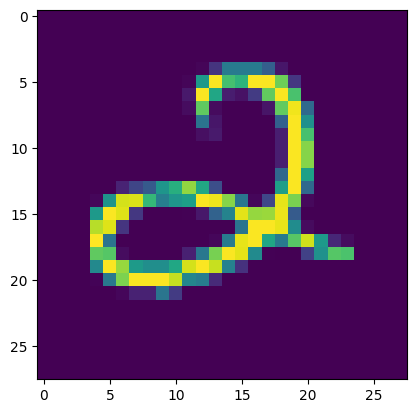

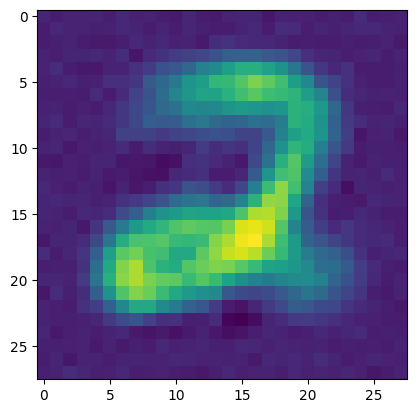

In [10]:
with torch.no_grad():
    for idx,batch in enumerate(dataloader):
        samples = batch['samples'].to(device)
        latent = enc(samples)
        img = gen(latent).reshape(32, set_size, 28, 28)
        metadata = [b.item() for b in batch['metadata'].cpu()]

        print(metadata)

        plt.imshow(samples[1][0].cpu().reshape(28, 28))
        plt.show()

        plt.imshow(img[1][0].cpu())
        break

In [ ]:
import sys
import os
import hydra
from omegaconf import OmegaConf

# add parent directory to path
sys.path.append(os.path.abspath(os.path.join('..')))

# initialize hydra

In [ ]:
hydra.initialize(config_path="config", version_base="1.1")

hydra.initialize()

In [ ]:
cfg = hydra.compose(
    config_name='config',
    overrides=["experiment=mnist_multinomial",
                "encoder=wormhole_encoder",
                "generator=ddpm"]
)

In [ ]:
encoder = hydra.utils.instantiate(cfg.encoder)
generator = hydra.utils.instantiate(cfg.generator)

In [ ]:
cfg.generator

{'_target_': 'generator.ddpm.DDPM', 'model': '${model}', 'betas': [0.0001, 0.02], 'n_T': 400, 'drop_prob': 0.1, 'noise_shape': '${dataset.data_shape}'}